# <center>Graph Theory as an Alzheimer’s Disease Diagnostic Instrument in the Context of Functional Brain Connectivity</center>

### Student: Dragos Stanciu // Supervisor: Dr Javier Escudero

#### University of Edinburgh

#### **High level** steps of this project

- **Filtering**
    - band-pass filter data into frequency bands of interest 
- **Functional Connectivity**
    - compute phase synchronisation for the different frequencies
- **Graph Theory**
    - create adjacency matrix, compute graph measures
- **Classification**
    - train different classifiers on graph measures

### Dataset

**MEG_AD_Thesis** contains the dataset of **80** subjects as follows:

- AD patients: 36
- MCI patients: 18
- Controls: 26

**Equipment:** 148 channels, 5min recordings, sampling frequency of 169.54Hz

#### Folder Structure
- **50863** -- contains raw signals for each subject with recordings split into the 148 channels.
- ** MEG_50863_noECG_10s ** -- contains **1380** clean, preprocesed recordings, with cardiac artefacts removed; e.g.: _MEGnoECG_38_segm15.mat_ contains preprocessed signals (**148** channels X **1695** time samples) for the subject ID 38, segment no 15. 
- **seleccion_libres_artefactos** -- contains matrices with info about which epochs are clean (for epochs of 10s); 0s where epochs should be discarded and 1s for epochs that should be analysed. _MEG_50863_noECG_10s_ contains just the epochs that should be analysed.

#### Files
- _rechazo_artefactos2.m_ -- marks clean epochs for given epoch length (use this if you need epoch length other than 10s)
- **_IDs_AD-MCI-CON.m_** -- subject IDs for AD, MCI and Controls
- _subjects_MEG_dementia.xls_ -- sociodemographic data for the dataset + extra people **NOT** to be included in the analysis


Start Matlab instance and add project folder to the Matlab search path:

In [1]:
%load_ext pymatbridge

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-38e1d927-d900-4ab6-ac69-0f878328b43d
Send 'exit' command to kill the server
......MATLAB started and connected!


/usr/local/lib/python2.7/dist-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


### Methods

Good for **writeup**: [signal processing and others](https://www.ncbi.nlm.nih.gov/pubmed/23940340)

#### Data Inspection and Integrity

**_OBS_**: Each subject has at least 4 clean epochs for the analysis, i.e. 40 seconds recording time. There are a total of 1380 valid epochs. 

We want to check if the recordings in _MEG_50863_noECG_10s_ contain any values other than floats (e.g. NUL, SOH, etc.). 

To do this, we would check each file within _MEG_50863_noECG_10s_ folder by loading and inspecting the recordings. A Matlab function which gets all files within a directory (recursively) was employed: _getAllFilesInDirectory(directoryName)_. 

An epoch in _MEG_50863_noECG_10s_ contains the following structures (for the _MEGnoECG_07_segm9_ example):
- _meg_no_ecg_ -- the actual recordings: 148 channels x 1695 samples
- _thisEpoch_ -- the epoch number (for segm9 is 9)
- _thisSubject_ -- the subject ID (for 07 is 07)

_checkIntegrity.m_ loads each file in _MEG_50863_noECG_10s_ and checks that:
- all recorded values are doubles and there are no NaN elements
- epoch numbers are positive and between 1 and 32
- subjectIDs are valid

Also checked that recordings for all 80 patients in *IDs_AD-MCI-CON.m* are present.

### Preprocessing

#### Filtering

##### Subtraction of Mean (yes, need to do it)

> _As we want to work with oscillations around 0, we need to subtract the mean at each time-step for each channel. In other words, for a matrix of MEG data (channels x time samples), we want the average of each column to be 0 (average reference). This can be done with the code below (partially from [Matrix Algebra and Matlab](http://imaging.mrc-cbu.cam.ac.uk/methods/MatlabLecturesSchedule?action=AttachFile&do=get&target=LectureOlaf.pdf))_

Therefore, we need to remove the DC offset (more here: [Brainstorm tutorials](http://neuroimage.usc.edu/brainstorm/Tutorials/TutImportRecordings#Import_recordings)). From the website:

>*This option removes the baseline value of each sensor, ie. the continuous (DC) offset that is added permanently on top of the recordings of interest. In MEG, the sensors record variations around a somewhat arbitrary level, therefore this operation is always needed, unless it was already applied during one of the pre-processing steps.
Note that a high-pass filter with a very low frequency (for instance 0.3Hz) can replace efficiently this DC correction. If a high-pass filter has already been applied to the recordings, you may want to unselect this option.*

It also seems this is optional (as per the link above), as I look at frequencies higher than 0.5 Hz (bandpass filter for delta band).
In summary, I need to do this to remove the baseline value of each sensor. For each channel, I take the mean of all samples and subtract it. (guess I can still use the code from [Matrix Algebra and Matlab](http://imaging.mrc-cbu.cam.ac.uk/methods/MatlabLecturesSchedule?action=AttachFile&do=get&target=LectureOlaf.pdf), might need taking some transposes)

I can use the *demeaning* parameter when doing *ft_preprocessing*: [DC offset explanation](http://fieldtrip.fcdonders.nl/faq/why_does_my_tfr_look_strange). It subtracts the mean of the whole recording--> that's good, as the mean is not biased, say, when using only the first few samples.



In [8]:
%%matlab
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%% Code snippet from blc.m in FieldTrip %%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% BLC does a baseline correction using the prestimulus interval of the data
%
%   [data] = baseline(data, interval);
%   [data] = baseline(data, begin, end);
%
% If no begin and end are specified, the whole timeinterval is
% used for baseline correction.

% determine the interval to use for baseline correction
%if nargin==1
% default is to use the whole timeinterval for baseline correction

###### Power lines (very low frequency waves and 50Hz)

State the problem and say that band-pass filtering should fix it, as the analysis is restricted for the interval (0.5, 45) Hz.

##### Band-pass Filtering

Following the preprocessing pattern of previous papers, I need to do 2 things:
1. use a low-pass filter to remove frequencies above 45Hz
2. band-pass filter for each band of interest: delta (0.5–4 Hz), theta (4–8 Hz), alpha (8-13Hz), beta (13–30 Hz) and gamma (30–45 Hz). Some papers further divide the alpha band in lower alpha (8-10Hz) and upper alpha (10-13Hz). I will maybe do this if necessary & available time. 

I see two possible methods of doing the filtering: 
- one would be to use _FDAtool_ to design the filter and then do the filtering with _filtfilt_. 
- another way would be to use the _fieldtrip_ toolbox as it has the built-in functions for preprocessing the data. _fieldtrip_ can also be used for computing the phase lag index (PLI) /weighted phase lag index (WPLI) for functional connectivity. The problem with this is that Alex said that it takes a lot of time to convert the data into the format compatible with the _fieldtrip_ toolbox... I have to try it anyway. Apparently, I need a header file to load the data in _fieldtrip_. ~~Ricardo should send this soon.~~ He sent it.

**_OBS_**: It would be good to do the filtering with both methods so I can compare the results. I will go with FieldTrip for now, as it might pay off in the long run, when it comes to compute functional connectivity (~~FDAtool + _filtfilt_ from Matlab~~) and do functional connectivity also with FieldTrip.

When it comes to filtering, Javier agreed that an **FIR filter** would be better than an IIR filter as it is more stable and is linear-phased (doesn't distort the phase) (see [FIR vs IIR](http://www.minidsp.com/applications/dsp-basics/fir-vs-iir-filtering)). The recommended FIR filter is a FIR designed using a Hamming window. The filter needs to be a high order one to ensure that the transition from the pass to the stop band is sharp. In FDATool, when selecting a window-based FIR, only the cut-off frequency(ies) need(s) to be selected. With a high-enough order, the transition from pass to stop will be abrupt.

>For a window-based FIR filter, an order of 560 is far more than enough. 
The filter will be very abrupt, you can check it in fdatool if you want 
to. As far as I remember, I have used the order of 560 most of the time. 
The reason is that Matlab requires the filter length (which is equal to 
the order+1) to be smaller than 1/3 of the signal length. So, 1695/3 = 
565 --> with 560 you are pretty close to the maximum order you can have.




#### Filtering in Matlab

After the mean has been subtracted to remove the DC offset, the next step is to filter the data. As I said above, we will use _FDAtool_ + _filtfilt_ to first low-pass filter to remove frequencies >45Hz and then band-pass filter in bands of interest.

Ricardo suggested to filter the data with padding in order to remove edge effects. In they're analysis, they pad the trials/epochs of interest with a no. of data samples corresponding to the order of the filter. Normally, this padding is done with the raw data. 

_Problem_: my cleaned epochs have been cleaned of the cardiac artefact - how should I do the padding? 

_Answer_: From Javier: It is indeed important to minimise transients. Apparently, _filtfilt_ is already taking care of this by extrapolationg beginning and end of the data sequence using reflection. Slopes of original and extrapolated sequences match at end points, reducing transients (_line 204 in filtfilt.m).

If I choose to pad: 
>_best to match amplitude value and the slope of the signal at the beginning and end. If you pad with 0s and the value of the signal is not 0 there, an artificial jump (i.e. transient) will be introduced. Padding is more about making sure that the filter does not come across big jumps and discontinuities than about bringing information from external epochs._

**OBS**: Javier thinks I don't need to pad and that I can use the whole length of the filtered epoch (all 10s).

_Problem_: It seems I don't need to pad. But when computing the WPLI, I need to take the Hilbert transform to get the phase. Ricardo recommended band-pass filtering with padding, then taking the Hilbert transform, then removing the initial padding. Is it ok not to pad when doing the Hilbert transform?

_Answer_:
>_The phase obtained from the Hilbert transform should be the 
instantaneous phase. Matlab computes the Hilbert transform via a DFT 
transformation so I am not sure padding will make much difference. I 
play a little with some data in Matlab and, as far as I see, the 
differences of using padding or not are minimal._

-------------- EMAIL 6/07/2014 --------------------------------------

>_First of all, an important point I forgot to take into account in my 
previous email (and code) is that the computation of the phase using the 
Hilbert Transform is properly defined for narrow-band signals. I'm 
afraid this is not fulfilled for the example using random numbers in my 
previous email. Please, accept my apologies. If possible, I would 
recommend you applying a band-pass filter to your examples. For the 
MEGs, the bands of delta, theta and alpha are relatively narrow, but you 
may want to split beta and/or gamma into narrower sub-bands.
However, I agree with your 2nd email that not using padding should be OK.
If you decide to use padding, please, use the symmetric extension._ 

**OBS**: Checked Javier's code in **Testing**. Also checked how padding Javier's way and padding using symmetrical extension affect the phase of MEG signals. It seems that padding very little changes the phase. I will not pad, unless the WPLI  measure (sliding window for phase differences) affects the results.

Need to check how the phases are after doing the Hilbert transform for the **prefiltered** padded/unpadded signal into a bandpass.


_Problem_: In this project, I look at functional connectivity as measured by looking at phase synchronisation. It is important that the phase of the signals should not be distorted during the processing. The epochs I'm working with have been cleaned of the cardiac (ECG) artefact. Does this cleaning affect the phase? 

_Answer_: 
>_ICA might affect slightly the phase of the recorded activity in the 
sense that a constraint ICA is used to estimate the cardiac artefact, 
and then this signal is subtracted from the MEG recordings. So, 
basically, one signal (the same signal!) resembling the Cardiac Artefact 
was subtracted from all channels. Because we subtract a signal, we will 
modify the amplitude and phase of the MEGs. However, the signal is the 
same for all channels, so the same amplitude and phase is equally 
subtracted and, therefore, I believe that this will minimise the chances 
of inserting spurious results in the phase difference between signals. 
It is not like we are performing ICA on all MEG channels and then 
performing a partial reconstruction. However, the jury is still out on 
whether it is better to remove the cardiac artefact this way or not._

**OBS**: Javier suggested testing both approaches: analyse the signal with the cardiac artefact rejection and the raw data (_50863_) using the same epochs. Will do the comparison **if** I have the time.

In [ ]:
# seems that filtering will be done with FieldTrip in the end. See below.

#### Filtering in _FieldTrip_

Next step is to see how can I use _fieldtrip_ to do the filtering with an FIR filter.

##### **4D_header_adapted.mat** (modified from Ricardo)

- Channels are labelled as A1 to A148. Just replace the header.label cell array for one with those labels (sorted as the ones in your data). The first row of your data, the time, is not needed here.
    - I have to label the channel from A1 to A148 _Done._
- Change the number of channels (nChans) to 148, and the number of samples (nSamples) for that of your data (depends on the lenght of the data, as you can imagine)
    - I have to change _nChans_ to 148 and _nSamples_ to 1695 (as these are the values for my cleaned epochs) _Done._
- header.chantype must be a cell array of 148 items, each one containing the string 'meg'
    - I have to shrink the _header.chantype_ array to 148 elements and put 'meg' in all of them _Done._
- header.chanunit is the same, but with the string 'T' (for tesla)
    - same for _header.chanunit_, but put _'T'_ in the cells _Done._

Ricardo said to use this to save the data (for faster reading? I don't think I need this...): [Write data to a more efficient format](http://fieldtrip.fcdonders.nl/faq/reading_is_slow_can_i_write_my_raw_data_to_a_more_efficient_file_format)

[FT_PREPROCESSING](http://fieldtrip.fcdonders.nl/reference/ft_preprocessing) is used to load the data. If trial definitions are not specified (I don't see a reason to do this), then *ft_preprocessing* would load all data and put them into a _[channels x time]_ array of a single trial (e.g. in _data.trial{1}_). They say that sooner or later, I need to segment the data into trials. I guess the trials can just be the epochs. 

I already have my clean epochs, so I don't need to do the segmentation.

Sample code  
>%%matlab  
cfg.trl = trl; % saved somewhere previously  
cfg.dataset = 'exampledata.eeg'; % data file, you might also need to add the path to it  
trialdata = ft_preprocessing(cfg); % call preprocessing, putting the output in 'trialdata'

The first 2 columns from _trl_ that described the start and end samples of a trial in the original data are now found in _trialdata.sampleinfo_. 

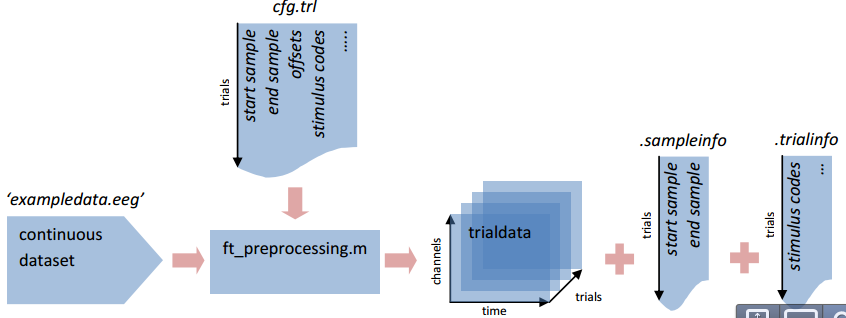

In [12]:
from IPython.core.display import Image
Image(filename='./img/preprocessing.png') 

I have modified the header file from Ricardo. Now I need to load the data with FieldTrip and filter into the bands.

*FT_PREPROCESSING*:

Configurations for _cfg_ structure:

- demean
- ...

Configurations for data:

- **Time vector** 
   
    The clean epochs do not have a time vector associated with them. I need to generate that and supply it to the _data_ structure. Code for this can be found in _getTimeVectorFor10sEpoch.mat_. Initially, knowing that my epochs have 1695 samples, I tried to take the time vector for the first 1695 samples from the raw data. The problem was that the values in the time vector were multiplied by 10^5. I understand from Alex that this is a problem with the data coming from Excel, where decimals in the Spanish data file used commas instead of dots. I simply multiplied the values by 10^(-5) and that solved the problem.
       
    





### Frequency Analysis

Welch's Method -- say how it works and maybe how you implemented it in FieldTrip (redefined 10s epoch in segments of 2s length with 50% overlap). 
Also, when performing frequency analysis in the gamma band, multitapers have been employed for better control over frequency smoothing: [Multitapers (Frequency Analysis tutorial FieldTrip)](http://fieldtrip.fcdonders.nl/tutorial/timefrequencyanalysis#time-frequency_analysis_iii)

Used +/-4Hz for gamma band i.e. 8Hz smoothing box (with this as reference *(Mitra and Pesaran (1999) Analysis of dynamic brain imaging data. Biophys J. 76(2):691-708)
3) Percival and Walden, 1993 Spectral analysis for physical applications: multitaper and conventional univariate techniques. Cambridge, UK: Cambridge UP.)*. 

REFERENCE: From *Good Practice for Conducting and Reporting MEG Research*:

>The bandwidth of the different frequency components in electro- physiological data increases with frequency. Also, across subjects, there is variability of the peak frequency (e.g. of the subject-specific gamma-band oscillatory activity) that is more pronounced for the higher frequency bands. For optimal sensitivity, it is therefore recommended to increase frequency smoothing at higher frequen- cies: for example, to apply little smoothing for frequencies below about 30 Hz (e.g., a fewtapers implementing up to 2 Hz smoothing), but greater smoothing at higher frequencies, particularly above 50 Hz (e.g.,multiple tapes implementing up to 10–15 Hz smoothing) (Hoogenboom et al., 2006; Schoffelen et al., 2011)



It is recommended for frequencies below 30Hz to use a single taper, e.g. Hanning. This is the one that was used for analysis in [delta-beta] bands.

### Functional Connectivity

No single functional connectivity measure is significantly better than the others ([paper on neural mass models that says that](http://www.sciencedirect.com/science/article/pii/S0165027014000363)). They advise to look at multiple measures simultaneously... 

From [Mailing List](http://mailman.science.ru.nl/pipermail/fieldtrip/2012-November/005917.html):
>*Just for the very very last time I will make the following statement:
Single trial coherence estimates cannot be computed!
Perhaps the font size and color will make it memorable ;-). This is due to the simple fact that coherence is defined across observations. If you have just a single observation, due to the mathematics involved, the coherence value will be 1.*

From [Mailing List](http://mailman.science.ru.nl/pipermail/fieldtrip/2013-May/006564.html):
>*For all these connectivity measures, we need the phase information from 
the Fourier transform (FFT) to compute the cross-spectral density matrix 
(CSD). The CSD can be regarded as the equivalent in the frequency domain 
to the covariance matrix in the time domain, thus it is a measures how a 
certain channels activity is co-modulated with another channels activity 
(for a particular frequency) - makes pretty much sense to make use of 
this when computing connectivity, right? :)
As you might know, a Fourier transform returns complex numbers, where 
the imaginary part of this number contains phase information. When 
calling ft_freqanalysis, you can decide if it shall only return the 
(squared) real part of the frequency spectrum (cfg.output='pow'), or 
instead the full CSD (cfg.output = 'powandcsd'). Alternatively, you can 
also let ft_freqanalysis return the raw Fourier coefficients 
(cfg.output='fourier'). From the Fourier coefficients, however, you can 
easily obtain the CSD or the power spectrum basically by multiplication 
the Fourier matrix with itself (transposed). All of these measures 
quantify the phase relation between channels across trials, and as phase 
information is coded in the imaginary part of the fourier output, thus 
for connectivityanalysis you need the CSD which can be obtained either 
by 'powandcsd' or by 'fourier'.*

From Javier, email 07/07/2014

>*For each MEG epoch, we do not have a clear, well defined event that marks the 
beginning of the epoch, it is just ongoing activity that happened to be 
divided into epochs in that way. Still, it may be beneficial to compute 
the WPLI over shorter windows and the to average the results over the whole epoch, as measuring a phase difference over a relatively long signal of 10s may be more challenging.*


It was agreed to use the weighted phase lag index (**WPLI**) [Vinck _et al._, 2011] as a phase synchronisation measure, as it is superior in terms of volume conduction, noise and sample-size bias. **Coherence** is another classic connectivity measure that can be used as a reference for comparing the results of the WPLI. 

#### Weight Phase Lag Index (WPLI)

##### Hilbert Transform

>_Basically, if you filter your signal in a particular band (which is what is done in EEG/MEG/ECoG analysis) then you're forcing your data to assume a sinusoidal, oscillating state. Once you have this filtered (discrete) time-series signal you can then calculate the instantaneous phase at any given time point._ (from [Hilbert Quora](https://www.quora.com/How-does-the-Hilbert-transform-lead-to-instantaneous-phase-of-a-signal)) 


We pretty much have zero phase at peaks and +/- PI phase at throughs. Hilbert transform is used to extract those phase values.

Need to take the Hilbert transform of the signals to obtain the instantaneous phase. It is good that we prefiltered into specific frequency bands as this is needed for the Hilbert transform when restricting the analysis to certain frequencies ([Phase synchronisation](http://www.scholarpedia.org/article/Measures_of_neuronal_signal_synchrony#Phase_synchronization), Quian Quiroga, 2002). 

Also understand [Hilbert transform for brain waves](http://www.scholarpedia.org/article/Hilbert_transform_for_brain_waves) and look at [hilbert Matlab](http://www.mathworks.co.uk/help/signal/ref/hilbert.html) for summary.

In Matlab, _hilbert(matrix)_ operates columnwise, finding the Hilbert transform of each column. As we need to compute the analytic signal for each channel over time, we need to transpose the 148 channels X 1695 time samples matrix.


### FieldTrip 

The actual computation of the connectivity metric is done by *ft_connectivityanalysis*. 

#### Output options in *ft_freqanalysis* [Output Explanations](http://fieldtrip.fcdonders.nl/faq/in_what_way_can_frequency_domain_data_be_represented_in_fieldtrip)

Need to figure which one is the best one, considering I also want to compute connectivity.

- 'fourier' as output: most basic representation as both power and cross spectra can be obtained from the fourier-representation of the data.

*ft_connectivityanalysis()* on frequency domain data containing fourier-spectra w/o specifying cfg.channelcmb will result in yet another representation of frequency domain data. For a quantity like the coherence spectrum the values across the diagonal are symmetric.

If I want to use *ft_connectivityplot()*, I need to change some parameters when computing the frequency: [Connectivity Tutorial](http://fieldtrip.fcdonders.nl/tutorial/connectivitynon-parametric_computation_of_the_cross-spectral_density_matrix). Question is: do I want to use ft_connectivity plot()? :)

>It is not necessary to compute the cross-spectral density at this stage, because the function used in the next step, ft_connectivityanalysis, contains functionality to compute the cross-spectral density from the fourier coefficients.

So the parameters I need to use are:
- cfg.method    = 'mtmfft';
- cfg.taper     = 'dpss'; 
- cfg.output    = 'fourier'; // this is the important one
- cfg.tapsmofrq = 2; // amount of spectral smoothing through multitapering

Normally I would set _cfg.output_ to the _powandcsd_ option, but _ft_connectivityanalysis_ does the csd for me. More info on why 'fourier' should be used: [mailing list](http://mailman.science.ru.nl/pipermail/fieldtrip/2011-March/003671.html).

OBS: Also need to set _cfg.keeptrials_ to _'yes'_ which doesn't average the frequency analysis over the trials. This is needed as the functional connectivity analysis needs separate epochs for 

#### **OBS**: Gamma Band Time Frequency Analysis

When it comes to _Gamma_ band filtering, make sure to use multitapering for better control over frequency smoothing [Time Frequency Analysis](http://fieldtrip.fcdonders.nl/tutorial/timefrequencyanalysis#time-frequency_analysis_iii). For all other frequencies of interest (delta-beta) the Hanning window is ok as the frequencies are below 30Hz.




#### Coherence

From [Mailing List](http://mailman.science.ru.nl/pipermail/fieldtrip/2013-May/006564.html):
>You should think of coherence more as a measure for the consistency of the phase relation between channels across trials, so coherence is just not defined per trial, neither would it make sense to compute 
coherence for a single trial.

I can calculate connectivity analysis via the imaginary part of coherency ([here](http://mailman.science.ru.nl/pipermail/fieldtrip/2013-February/006211.html)) by specifying _cfg.method = 'coh'_ in conjunction with _cfg.complex = 'imag'_.

Obs: The coherence measure is a symmetric measure, which means that it does not provide information regarding the direction of information flow between any pair of signals.


In [1]:
%%matlab
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%% Code for computing coherence
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

    %%% frequency analysis
    cfg = [];
    cfg.method = 'mtmfft'; %% entire spectrum for the entire data length
    cfg.taper = 'hanning';
    cfg.foilim=[0.5 4];
    cfg.output = 'fourier'; %% csd computed in ft_connectivityanalysis
    cfg.channel = header.label;
    cfg.keeptrial = 'yes'; %% keep individual trials for connectivity step
   
    [freq] = ft_freqanalysis(cfg, processedData);
    
    %%% connectivity
    cfg = [];
    cfg.channel = header.label;
    cfg.method = 'coh'; %wpli_debiased'; %% connectivity measure 
    stat = ft_connectivityanalysis(cfg, freq);

ERROR: Cell magic `%%matlab` not found.


### Plotting in FieldTrip

Layouts are an essential element in FieldTrip, and many FieldTrip functions rely that the user specifies a layout in his configuration (_cfg.layout_).

In order to plot coherence or other connectivity measures between channels, FieldTrip needs to be specified a layout file. This layout file contains positions of the 2D coordinates of the sensors for plotting. I will use the standard layout file which is included in FieldTrip. This is based on the MAGNES 2500 WH, 4D Neuroimaging machine which was used to collect the data.

#### Feature Extraction

Good for writing up ([inspiration](http://onlinelibrary.wiley.com/doi/10.1002/hbm.22353/full)): 
>In machine learning and image processing, feature extraction and feature selection are a special form of dimensionality reduction. Feature extraction is a dimensionality reduction approach that projects (linear or nonlinear) D-dimensional vector onto d-dimensional vector ( inline image), while feature selection is an approach that selects a small subset of original features. The aim of feature extraction and feature selection is to prevent the curse of dimensionality problem [Guyon and Elisseeff, 2003] and to identify the relevant features that leads to better performance of learning models.

>In the connectivity networks (matrices), there exist a large number of low level features (i.e.,  inline image, where n is the total number of ROIs) but with small subject size. To reduce the dimension of data and to find out the biomarkers for MCI diagnosis, it is crucial to extract meaningful features from the connectivity networks. The connectivity networks can be characterized at different levels, ranging from properties characterizing a whole network at global scale to properties of network components at local scale


From: [Brain Network Analysis: Separating Cost from Topology Using Cost-Integration](http://www.plosone.org/article/info%3Adoi%2F10.1371%2Fjournal.pone.0021570) (found out about it here(Graph analysis of functional brain networks: practical issues in translational neuroscience), in reading the between group comparison sections:

>a second approach is to compare the properties of the brain graphs by integrating the topological metric over a collection of available thresholds, as in [97] 


>something like this: "From each association matrix, a binary adjacency matrix A was derived where aij was considered 1 if rij was greater than a specific threshold and zero otherwise. The diagonal elements of the constructed association matrix were also set to zero. The resultant adjacency matrix represented a binary undirected graph G in which regions i and j were connected if gij was **unity**" (from [here](http://www.biomedcentral.com/1471-2377/12/28#B39))

>When this is not the case, or when one is comparing two populations of weighted networks, the question of whether or not these networks have similar topological properties becomes arduous

We threshold the connectivity matrix at with a range of values so as to not restrict the analysis to just a certain value. (cite this here: *M. Rubinov and O. Sporns, “Complex network measures of brain connectivity: uses and interpretations,” NeuroImage, vol. 52, no. 3, pp. 1059–1069, 2010. View at Publisher · View at Google Scholar · View at Scopus) ([good paper for writeup](http://www.hindawi.com/journals/cmmm/2012/186353/#B27)*)
>(connectivity networks are intrinsically fully connected, to reflect different levels of topological structure of the original connectivity network, we simultaneously threshold the connectivity network with different predefined values.)

To account for the different noise levels between subjects, we use a proportional threshold T, keeping N strongest connections, where T is chosen like in (Altered small-world properties of gray matter networks in breast cancer):

1. T takes the value of the minimum density that satisfies the requirement that all individual subject graphs are connected (connectedness, the ability for every node to reach every other node in the network).

2. T takes a range of values 

Similarly to the study **[HERE](http://www.sciencedirect.com/science/article/pii/S1053811911011633)**.

>The set of networks from a particular clinical group can be thresholded to create either equi-sparse graphsor equi-threshold graphsWe chose to construct equi-sparse graphs in order to ensure the most direct mathematical comparability of graph metric values (Bullmore and Bassett, 2011). [.....] This “cumulative” thresholding procedure has been used extensively in previous functional brain network studies because it facilitates an investigation of a network composed of the x% statistically most significant connections ( Bullmore and Bassett, 2011).


Similarly to the study [HERE](http://www.biomedcentral.com/1471-2377/12/28#B26) (go in paper and cite the papers they referenced themselves for this methodology),
>E equal to number of edges (links), and a network density (cost) of D = E/[(N x (N-1))/2] representing the fraction of present connections to all possible connections. Since thresholding the association matrices of different groups at an absolute threshold results in networks with a different number of nodes (and degrees) that might influence the network measures and reduce interpretation of between group results [37], 

we employed two approaches for thresholding the adjacency matrices:
1) Thresholding the constructed association matrices at a minimum network density in which all nodes become fully connected in the brain networks of both group

>Certainly, a good threshold should neither filter all the possible links nor let them all survive. Indeed, analyzing brain graphs that are either almost empty or fully connected appears to be worthless [8] (From Graph analysis of functional brain networks: practical issues in translational neuroscience)

##### Graph Measures

The following graph measures were used as features for the classification task:
(http://www.sciencedirect.com/science/article/pii/S1053811913002772) (Reference Rubinov and Sporns, 2010 Complex network measures of brain connectivity..)

"The **small-worldness** measure should not be regarded as a substitute for individual assesments of itnegration and segregation"! (Rubi, Spor)

- **clustering coefficient** (C) (use the average)
- **characteristic path length** (L) (aka average shortest path) - most common for network integration (Rubi, Sporns, 2010) - requirement: need the graph to be connected
- betweenes centrality (BC) (use the average) - fraction of all shortest paths in the network that pass through a given node; high value means that the node has a crucial role in connecting the nodes of the network, pointing out a possible hub role of the node in the network.
- **modularity** (Q) - describes possible communities in the network
- **Eigenvalue centrality** (EC)
- **small-worldness** (SW) - has a high C and low L - high integration and high segregation
- **global efficiency** (average inverse shortest path - used instead of characteristic path length as L is not robust for networks with disconnected nodes from Graph analysis of functional brain networks practical issues look in notes)
- local efficiency
- measure of centrality: degree 
- assortativity?

To further evaluate the network structure, a graph analysis based on WPLI was used to determine clustering coefficient (C) and betweenness centrality (BC) as local coefficients as well as the characteristic path length (L) as a parameter for global interconnectedness. The network’s modular structure was also calculated to estimate functional segregation.

From BCT page:

1. Measures for binary and undirected networks will often be faster to compute than measures for weighted and directed networks. 
2. **Most network measures should be compared with measures computed on corresponding reference (null model) networks** (https://sites.google.com/site/bctnet/null) (randomizer_bin_und.m or randmio_und.m)

Create **100** random networks from each connectivity matrix that will respect the number of nodes, edge distribution, node degree. Each edge of the initial matrix was rewired ***1000*** times. [REFERENCE](http://www.plosone.org/article/info%3Adoi%2F10.1371%2Fjournal.pone.0096196)
Considering the fact that we would have to generate 100 random networks for the connectivity matrix of each frequency band, for each threshold, for each subject (LIMITATION), the computational requirements of this task would be too demanding. For this reason, we have chosen to change the parameters to 10 generated networks with 40 rewiring iterations per edge.

OBS/DISCUSSION: For low thresholds, the graph becomes more segmented and multiple graph components may appear. In consequence, networks topology measures may be distorted by these individual connected networks. This would be an explanation for the variabity of the curve for these low threshold values.

#### Modularity Obs
No single agreed measure ([here, maybe find better ref](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3777708/)) Like in the just cited paper, we used the Louvain algorithm for fast community detection ([Louvain paper](http://arxiv.org/abs/0803.0476)).
"Since modularity Q values can vary based on random differences in module assignments from run to run" (MUST SEE: modularity_und.m (Ci and Q may vary from run to run, due to heuristics in the algorithm. Consequently, it may be worth to compare multiple runs)) 

### Statistical Testing

- Functional Data Analysis (FDA) for graph curves [here](http://www.sciencedirect.com/science/article/pii/S1053811911011633)

- can also use ANOVA

#### Feature Selection

OBS: Dependencies between features SW are dependent on C and L

Can also use MMSE and age as features for the classification.

#### Classification

OBS: Feature Scaling: explain Z-transform (StandardScaler in sklearn)

LOOCV
Feature scaling is done on each iteration of LOOCV. The mean and standard deviation of the features of the training set for that specific iteration are taken into account when doing feature scaling.

From [here](http://www.russpoldrack.org/2012/12/the-perils-of-leave-one-out.html):
>One thing that we always do when running any predictive analysis is to perform a randomization test to determine the distribution of performance when the relation between the data and the outcome is broken (e.g., by randomly shuffling the outcomes)

OBS: Might simply learn noise! Very likely not to be good for actual prediction... I don't know...
It's certainly a limitation (discuss it a bit).

#### SMOTE

Used code from https://github.com/blacklab/nyan/blob/master/shared_modules/smote.py

Used K=5, as that was the value used in the original paper.

### Discussion

#### Clustering Coefficient

Low values of C because of extra weight on low degree nodes (there are many of them in the 148x148 matrix). It says this on Wikipedia Clustering Coefficient.

### Future Work

- Source reconstruction

- Explore other measures (e.g. spectral analysis)

**WRITEUP**

- did not look at non-symmetrical measures such as Granger causality because the final goal was to develop a classifier to discriminate between the 3 categories and not ...

- very good [critical review](http://arxiv.org/pdf/1406.7391v1.pdf) of all steps in processing pipeline:

>functional brain networks are the result of a tricky processing pipeline (Fig. 1), which basically consists in improving the quality of the recorded brain signals, constructing the network by means of measures of pairwise functional connectivity, retaining the most relevant links, extracting graph metrics describing topological properties of the network and finally applying statistical procedures to the extracted graph indices to determine differences between populations

- Negative weights - page 4 in the above paper; explains why I take absolute value of the correlation coefficients.

- also consult [GAT toolbox](http://www.plosone.org/article/info%3Adoi%2F10.1371%2Fjournal.pone.0040709) when describing pipeline

In [15]:
%unload_ext pymatbridge

MATLAB closed
